# Random Sampling

In this notebook you'll work with the obstacle's polygon representation itself.

Your tasks will be:

1. Create polygons.
2. Sample random 3D points.
3. Remove points contained by an obstacle polygon.

Recall, a point $(x, y, z)$ collides with a polygon if the $(x, y)$ coordinates are contained by the polygon and the $z$ coordinate (height) is less than the height of the polygon.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Polygon, Point
%matplotlib inline 

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders2.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Create Polygons

In [16]:
def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        
        
        # TODO: Extract the 4 corners of the obstacle
        # 
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird
        # order.
        corners = [(north + d_north , east - d_east), 
                   (north + d_north , east + d_east),
                   (north - d_north , east + d_east),
                   (north - d_north , east - d_east)]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        # TODO: Once you've defined corners, define polygons
        p = Polygon(corners)
        polygons.append((p, height))

    return polygons

In [17]:
polygons = extract_polygons(data)

# Sampling 3D Points

Now that we have the extracted the polygons, we need to sample random 3D points. Currently we don't know suitable ranges for x, y, and z. Let's figure out the max and min values for each dimension.

In [18]:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 10

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 10


Next, it's time to sample points. All that's left is picking the distribution and number of samples. The uniform distribution makes sense in this situation since we we'd like to encourage searching the whole space.

In [19]:
num_samples = 100

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

In [20]:
samples[:3]

[(158.0579604230358, -385.4153889124204, 8.540920201565045),
 (236.45227325946968, -297.138448606827, 1.4771978730665414),
 (-168.93044952400635, 74.17984966782217, 6.874148270999277)]

## Removing Points Colliding With Obstacles

Prior to remove a point we must determine whether it collides with any obstacle. Complete the `collides` function below. It should return `True` if the point collides with *any* obstacle and `False` if no collision is detected.

In [38]:
def collides(polygons, point):   
    # TODO: Determine whether the point collides
    # with any obstacles. 
    
    for polygon in polygons:
        if polygon[0].contains(Point(point)) and point[2] <= polygon[1]:
            return True
    return False

Use `collides` for all points in the sample.

In [39]:
t0 = time.time()
to_keep = []
for point in samples:
    if not collides(polygons, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)

Time taken {0} seconds ... 5.542033910751343


In [40]:
print(len(to_keep))

68


## Points Visualization

In [41]:
from grid_v2 import create_grid
grid = create_grid(data, zmax, 1)

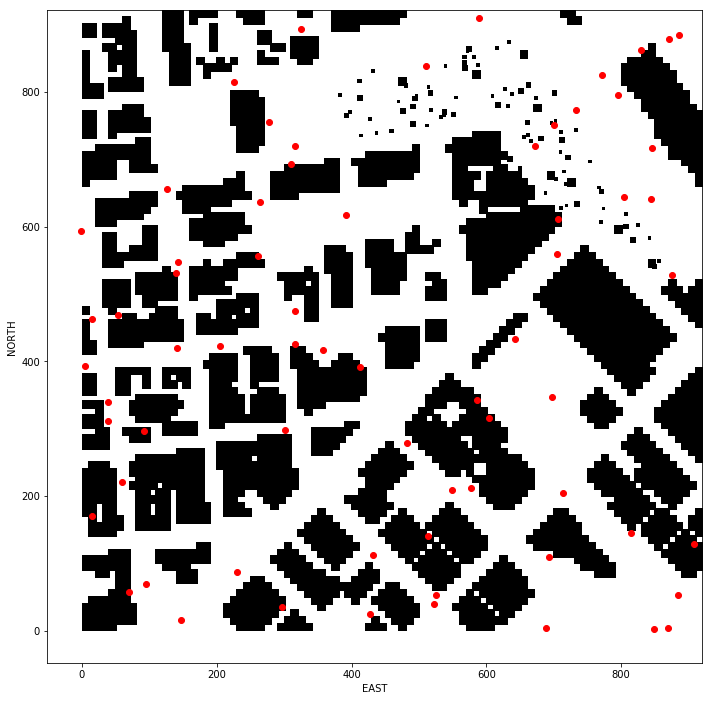

In [42]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='red')

plt.ylabel('NORTH')
plt.xlabel('EAST')

plt.show()

## Epilogue

You may have noticed removing points can be quite lengthy. In the implementation provided here we're naively checking to see if the point collides with each polygon when in reality it can only collide with one, the one that's closest to the point. The question then becomes 

"How do we efficiently find the closest polygon to the point?"

One such approach is to use a *[k-d tree](https://en.wikipedia.org/wiki/K-d_tree)*, a space-partitioning data structure which allows search queries in $O(log(n))$. The *k-d tree* achieves this by cutting the search space in half on each step of a query.

This would bring the total algorithm time down to $O(m * log(n))$ from $O(m*n)$.

The scikit-learn library has an efficient implementation [readily available](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree).